Met5 Data Cube
# Multitemporal Analysis of Seasonal Burns in Burkina Faso
by Jyoti Biswas, Magdalena Fischer, Lallu Praphatan and Ina Schulz


## Overview of the Study Area

The study area lies in the western part of Burkina Faso, which is covered in this WASCAL Data Cube. <br>
In Burkina Faso, the dry season lasts  from November to February, with heavy rainfall during the wet season from May to September. <br>
The land cover in this area is made up of dry, tropical rainforest in between of agricultural lands. There are fequent burns, both of anthropogenic and natural causes. However, vegetation recovers quickly without a change in land cover due to the fire (Liu et al. 2021).<br>

In general, an increase in land cover conversion from forest to agricultural land has been noted in the past decade (Gessner et al. 2015).

The region of interest for this exemplary application was chosen based on qualitative analysis of the FIRMS Fire Map by NASA.
Tere Forest is a National Forest of Burkina Faso. With an average elevation of 340 m above sea level (asl) it rises above the surrounding planes with the elevation just under 300 m asl (Google Earth 2022).<br>
The forest itself is not used for crop farming, which is in stark contrast to the agricultrurally used lands surrounding the forest.
These are still littered with trees within fields or along borders.

In [1]:
# Import all needed packages
import datacube
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray as rio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
import geopandas as gpd
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices

In the following two cells, an application is created on the dataube called Brunt Area Mapping. <br>
Afterwards, parameters for the dataset that will be loaded from the cube are defined.  <br>
These can be adjusted in the area of interest including a certian area around a point of interest, the applicable timeframe and the products to be used for analysis. <br>
The buffer can be adjusted to any size, smaller areas of interest lead to more rapid computing. <br>

The time frame used for these analyses is four fire seasons. This can be changed any number of seasons. <br>
For the purpose of visualisation in this script, it is recommended, to use timesteps of four fire seasons at once. <br>
Then,  a list of the selected years is created, which will be used in further analyses. <br>

The minimum resolution is dictated by the loaded product. In this case, we use Landsat 8 which has the resolution of 30 m <br>
The various bands are loaded in measurments. <br>
In order to use only images which are not covered in clouds, the band pixel_quality is used in the variable min_gooddata, to use only images with less than 60% cloud cover. <br>

In [2]:
dc = datacube.Datacube(app="Burnt_area_mapping")

In [3]:
# Define the area of interest
lat = 11.69 #12.016
lon = -4.425 #-4.475
buffer = 0.1 # in decimal degreees

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

# Define timeframe, 4 fire seasons from october til may (data available from october 2013)
time = '2017-10-01', '2021-05-01'

# Create list including all loaded years
list_years = np.unique(dc_reproject.time.dt.year.values)

# Choose the Landsat 8 products to load
products = ["ls8_sr"]

# Define resolution
resolution = (-30, 30)

# Define needed bands
measurements = ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2', 'pixel_quality', 'radiometric_saturation']

# Define cloud mask threshold
min_gooddata = 0.6

Next,  the previously defined parameters are combined into a query, which can be adjusted easily and is taken into account in the following cell

In [4]:
# Create a reusable query with all needed parameters
query = {
    "x": lon_range,
    "y": lat_range,
    "resolution": resolution,
    "measurements": measurements, 
    "output_crs" : "EPSG:6933",
    "products": products,
    "min_gooddata": min_gooddata,
    "time":time
}

The function load_ard, which is developed by Digital Earth Africa, is used to load the previously defined data from the data cube. <br>
The number of datasets and the number of quality datasets are listed after executing the cell. <br>
With a revisit time of 8 days in Landsat 8, three images are taken each month.  With the pixel quality parameter, in mind this leads to only few useful images each season.

In [5]:
# Load all data based on set parameters avalible from ARD data
baseline_ard = load_ard(dc=dc,
                        group_by='solar_day',
                        **query)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr


/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class CommonTimestamp will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  return self._connection.execute(select_query)
/opt/conda/lib/python3.9/site-packages/datacube/drivers/postgres/_api.py:564: SAWarning: Class Float8Range will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  

Counting good quality pixels for each time step
Filtering to 52 out of 77 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 52 time steps


In the following cell, the normalized burn ratio is calculated from the loaded Landsat 8 collection (C2). <br>
In case Sentinel 2 data shall be used, the collection must be specified as 's2'.

In [6]:
# Calculate NBR for the whole loaded datacube
baseline_ard = calculate_indices(baseline_ard,
                                 index='NBR',
                                 collection='c2',
                                 drop=False)

The dataset is then reprojected into WGS 1984, which uses decimaldegrees instead of UTM coordinates, like the previously used coordinate system.

In [7]:
# Reprojct datacube to WGS84
dc_reproject = baseline_ard.rio.reproject("EPSG:4326")

## Normalized Burn Ratio

The Normalized Burn Ratio (**NBR**) is an index for identifing burnt areas. It uses the differences in the refelctance between green, healthy vegetation and burnt vegetation. For calculating the NBR the Near Infrared Band (NIR) aswell as the Shortwave Infrared Band (SWIR) is needed. The NBR values range from -1 to 1, whereby negative values represent burnt vegetation or bare soil and positive values indicate healthy vegetation.
The NBR is calulated as followed:
     
                                                                    NBR = (NIR - SWIR)/(NIR+SWIR)

## Delta Normalized Burn Ratio

By calculating the difference between the NBR from before the fire season and the NBR after the fire seasons the changes can be detected. Since the delta Normalized Burn Ratio (**dNBR**) values represent the change in the area, it can be more usefull to detect areas where a burning event has happened.


                                                                   dNBR = NBR(pre) - NBR(post)
                                                                  
The positive values of the dNBR generally represent burnt areas, whereas negative values indicate unburnt areas. Furthermore, based on the values assumtions about the severity can be drawn:


> $\lt$ -0.25 => *High post-fire regrowth*\
-0.25 to -0.1 => *Low post-fire regrowth*\
-0.1 to 0.1 => *Unburned*\
0.1 to 0.27 => *Low-severity burn*\
0.27 to 0.44 => *Moderate-low severity burn*\
0.44 to 0.66 => *Moderate-high severity burn*\
$\gt$ 0.66 => *High-severity burn*

### RGB Plot of the Area  as well as NBR Median Pre, During, Post Fire Plots

Visiualizing the NBR values for the different timesteps during one burning season shows already some changes in the refelctance. Based on the fire events registered on [FIRMS](https://firms.modaps.eosdis.nasa.gov/), October was choosen to represent the pre-fire season. Therefore, the fire season was defined to be from December til the end of March and the month April represents the post-fire season. During the wet season, the cloud cover is high, thus there is no available imagery with the required pixel quality.

Further the median along the time axis is used to achieve the best possible result.\
The following plots illustrate that the NBR reflectance in October is mostly above 0, indicating healthy, green vegetation. On the other hand the NBR reflectens values of the fire season and the post-fire season show lower values including negative ones which are indicators for burnt areas and less healthy vegetation. 


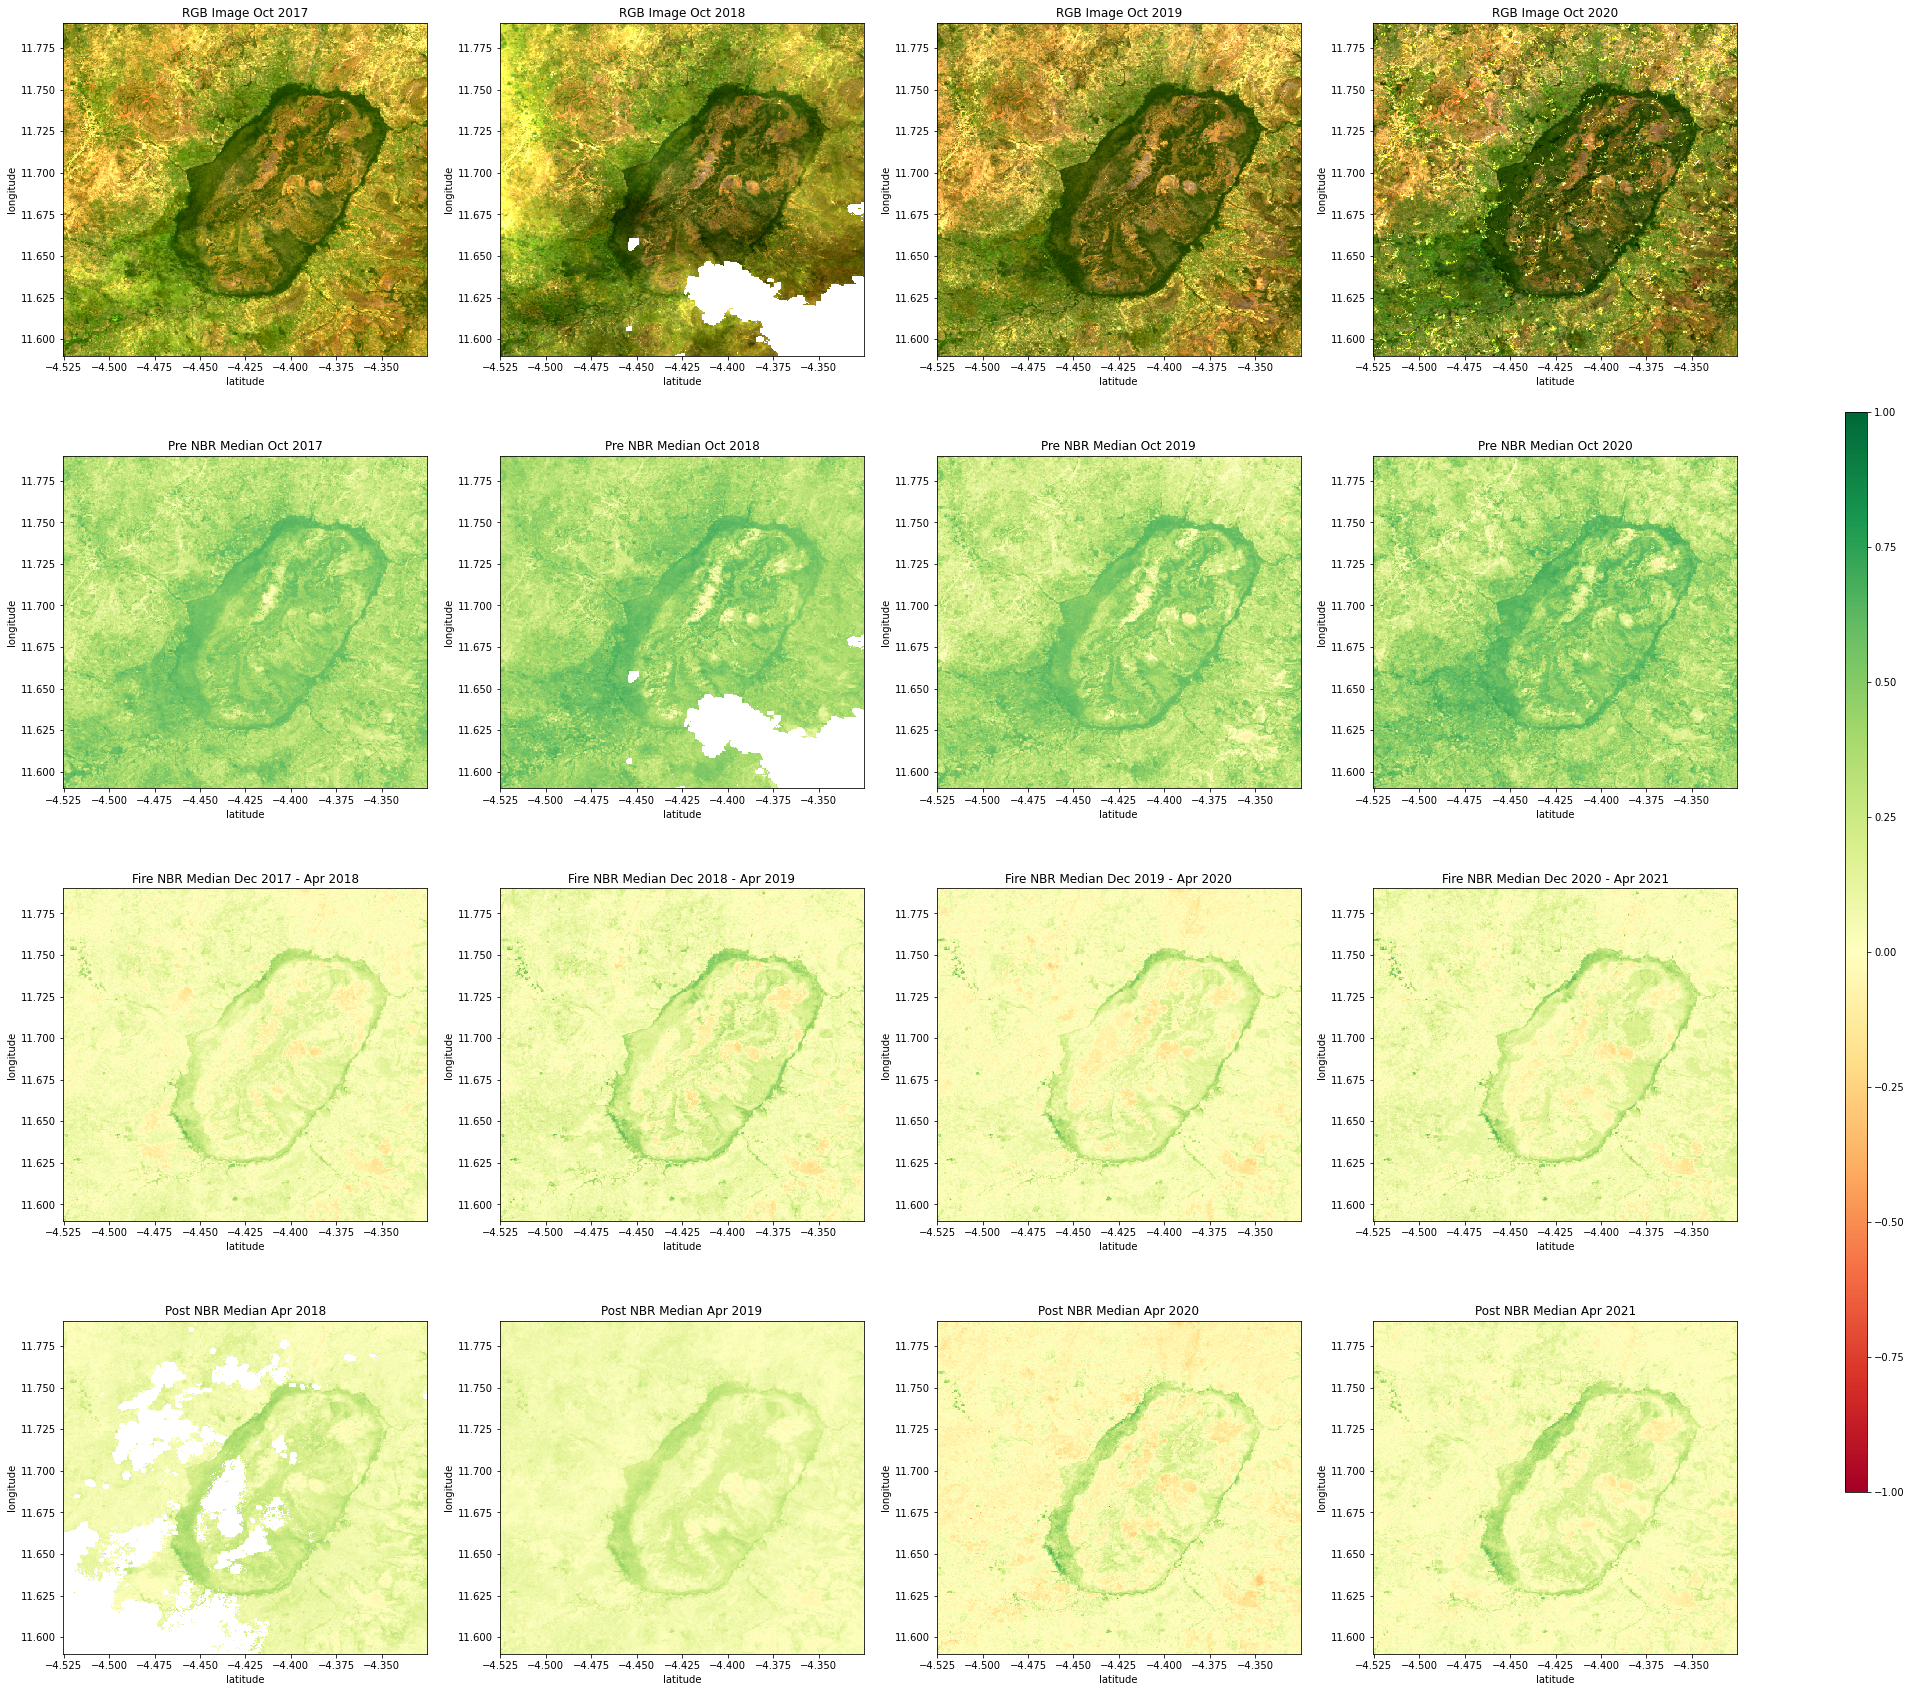

In [9]:
# Create plot frame with subplots for the four loaded seasons
f, axarr = plt.subplots(4, 4, figsize=(30, 30))

# Interate over the years creating pre, during and post fire subsets
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median 
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    fire_image = dc_reproject.sel(time=slice(str(pre_year) + '-12-01', str(post_year) + '-03-31')).median(dim='time')
    
    # Select NBR band
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
    fire_NBR_img = fire_image.NBR
    
    # Plotting RGB images
    rgb(pre_image, bands=['red', 'green', 'blue'], add_colorbar=False, ax=axarr[0, i])
    axarr[0, i].set_title('RGB Image Oct ' + str(list_years[i]))
    axarr[0, i].set_ylabel('longitude')
    axarr[0, i].set_xlabel('latitude')
    axarr[0, i].xaxis.set_visible(True)
    axarr[0, i].yaxis.set_visible(True)
    
    # Plotting pre fire NBR 
    pre_NBR_img.plot(cmap='RdYlGn', vmin=-1, vmax=1,
                  add_colorbar=False, ax=axarr[1, i])
    axarr[1, i].set_title('Pre NBR Median Oct ' + str(list_years[i]))
    axarr[1, i].set_ylabel('longitude')
    axarr[1, i].set_xlabel('latitude')
    axarr[1, i].xaxis.set_visible(True)
    axarr[1, i].yaxis.set_visible(True)
    
    # Plotting during fire season NBR
    fire_NBR_img.plot(cmap='RdYlGn', vmin=-1, vmax=1,
                  add_colorbar=False, ax=axarr[2, i])
    axarr[2, i].set_title('Fire NBR Median Dec ' + str(list_years[i])+' - Apr ' +str(list_years[i+1]))
    axarr[2, i].set_ylabel('longitude')
    axarr[2, i].set_xlabel('latitude')
    axarr[2, i].xaxis.set_visible(True)
    axarr[2, i].yaxis.set_visible(True)
    
    # Plotting post fire NBR
    im = post_NBR_img.plot(cmap='RdYlGn', vmin=-1, vmax=1,
                  add_colorbar=False, ax=axarr[3, i])
    axarr[3, i].set_title('Post NBR Median Apr ' + str(list_years[i+1]))
    axarr[3, i].set_ylabel('longitude')
    axarr[3, i].set_xlabel('latitude')
    axarr[3, i].xaxis.set_visible(True)
    axarr[3, i].yaxis.set_visible(True)
    
# Add one colorbar to all subplots, adjust spacing
cbar_ax1 = f.add_axes([0.95, 0.2, 0.01, 0.5])
f.colorbar(im, cax=cbar_ax1)
plt.subplots_adjust(hspace=0.3, wspace=0.2) 

#### Description of Results

The white pixels are no value pixels, which are most likely the result of cloud cover.
The ring of very healthy vegetation around Tere Forest is highly visible and still intact.

### Delta NBR and Burnt Area Plots

Using the dNBR as indicator for change, the visualisations below indicates burnt areas with positive values whereas unburnt areas are represented with negative values. A threshold of 0.44 was used to differentiate between moderately-high to high severity burnt areas (>0.44) and bare soil or low severity fires (<0.44). It is to be considered that clouds influence the results of the dNBR and of the burnt area. <br>
Since the unburnt vegetation also appears less green in the post-fire season due to changed conditions, the dNBR values are mostly greater than 0. Thus, the scale of the derived maps is adjusted to reach from 0 to 1. <br>
In a second step, a burn mask is created. Information on the severity of the burn is lost.

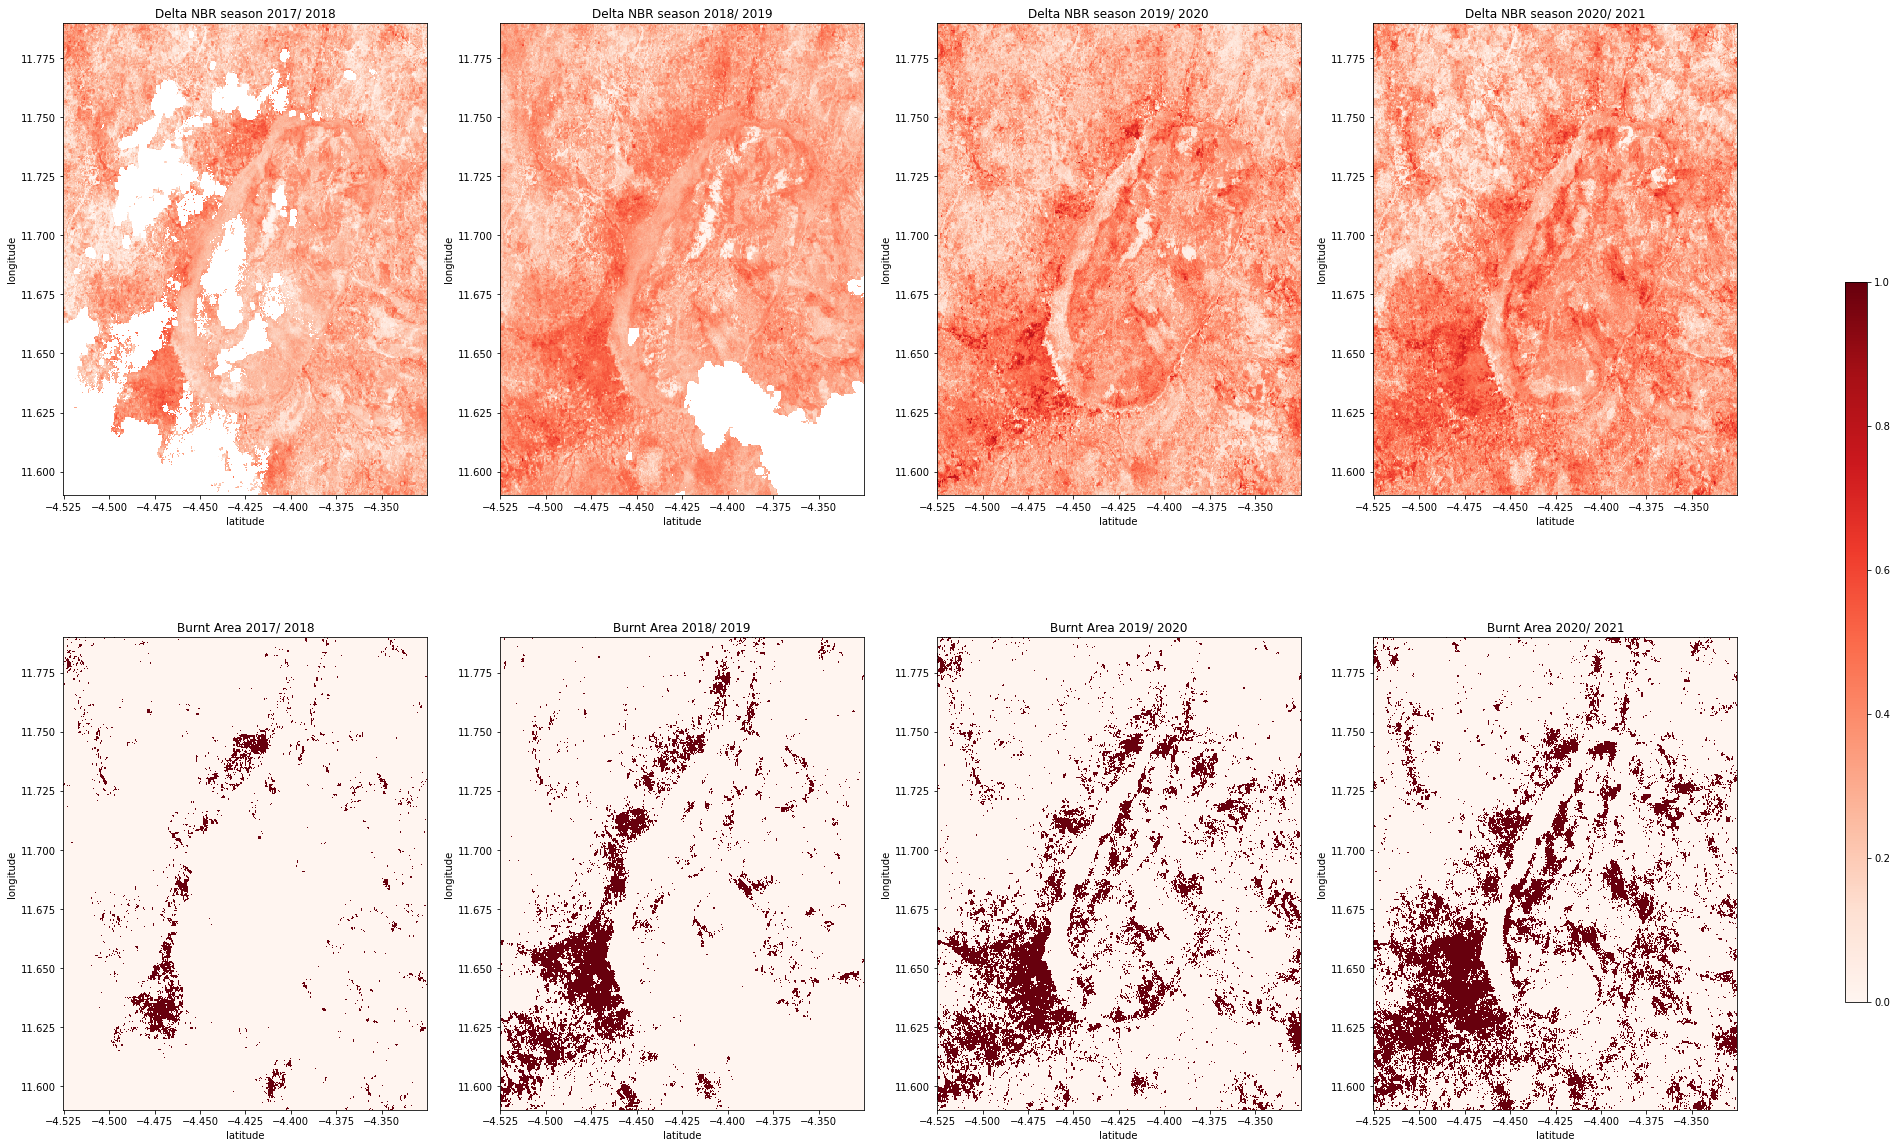

In [10]:
# Create plot frame with subplots for the four loaded seasons
f, axarr = plt.subplots(2, 4, figsize=(30, 20))

# Interate over the years creating delta NBR and burnt area subsets
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    
    # Select NBR band
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
        
    # Calculate delta NBR
    delta_NBR = pre_NBR_img - post_NBR_img
    # Set threshold
    threshold = 0.44 #moderate-high severity burn
    # Apply threshold
    burnt = delta_NBR > threshold
    
    # Plot delta NBR
    im = delta_NBR.plot(cmap='Reds', vmin=0, vmax=1,
                  add_colorbar=False, ax=axarr[0, i])
    axarr[0, i].set_title('Delta NBR season ' + str(list_years[i])+'/ '+ str(list_years[i+1]))
    axarr[0, i].set_ylabel('longitude')
    axarr[0, i].set_xlabel('latitude')
    axarr[0, i].xaxis.set_visible(True)
    axarr[0, i].yaxis.set_visible(True)
    
    # Plot burnt area 
    burnt.plot(cmap='Reds', add_colorbar=False, ax=axarr[1, i])
    axarr[1, i].set_title('Burnt Area ' + str(list_years[i])+'/ '+ str(list_years[i+1]))
    axarr[1, i].set_ylabel('longitude')
    axarr[1, i].set_xlabel('latitude')
    axarr[1, i].xaxis.set_visible(True)
    axarr[1, i].yaxis.set_visible(True)   
    
# Create one colorbar for all subplots and adjust spaceing
cbar_ax1 = f.add_axes([0.95, 0.2, 0.01, 0.5])
f.colorbar(im, cax=cbar_ax1)
plt.subplots_adjust(hspace=0.3, wspace=0.2)

### Calculating Areas

In the next step, the extent of the burnt areas is calculated for each year. <br>
Finally, a percentage of area burnt is given.

In [13]:
# Iterating over all loaded years for calculating different areas
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    
    # Select NBR bands
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
    
    # Calculate delta NBR
    delta_NBR = pre_NBR_img - post_NBR_img
    # Set threshold
    threshold = 0.44 #moderate-high severity burn
    # Apply threshold
    burnt = delta_NBR > threshold

    # Constants for calculating burnt area
    pixel_length = resolution[1]  # in metres
    m_per_km = 1000  # conversion from metres to kilometres

    # Area per pixel
    area_per_pixel = pixel_length ** 2 / m_per_km ** 2

    # Calculate areas
    unburnt_area = (delta_NBR <= threshold).sum() * area_per_pixel
    burnt_area = burnt.sum() * area_per_pixel
    not_nan_area = delta_NBR.notnull().sum() * area_per_pixel
    nan_area = delta_NBR.isnull().sum() * area_per_pixel
    total_area = unburnt_area + burnt_area + nan_area
    print('\033[1m'+str(pre_year)+'/'+str(post_year)+'\033[0m')
    print(f'Unburnt area:                     {unburnt_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Burnt area:                       {burnt_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Nan area:                         {nan_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Total area (no nans):             {not_nan_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Total area (with nans):           {total_area.item():.2f} km\N{SUPERSCRIPT TWO}')
    print(f'Percentage of total area burnt:   {100*burnt_area.item()/total_area.item():.2f}%')
    print()
    print()

2017/2018
Unburnt area:                     377.30 km²
Burnt area:                       16.26 km²
Nan area:                         105.96 km²
Total area (no nans):             393.56 km²
Total area (with nans):           499.52 km²
Percentage of total area burnt:   3.26%


2018/2019
Unburnt area:                     407.70 km²
Burnt area:                       48.49 km²
Nan area:                         43.33 km²
Total area (no nans):             456.19 km²
Total area (with nans):           499.52 km²
Percentage of total area burnt:   9.71%


2019/2020
Unburnt area:                     424.13 km²
Burnt area:                       75.39 km²
Nan area:                         0.00 km²
Total area (no nans):             499.52 km²
Total area (with nans):           499.52 km²
Percentage of total area burnt:   15.09%


2020/2021
Unburnt area:                     395.01 km²
Burnt area:                       104.52 km²
Nan area:                         0.00 km²
Total area (no nans):          

In the years chosen for this example, the burnt area increases significantly from only 4.13 % to 20.92 % in from 2017/18 to 2020/21.
However, this might be an artificial increase do to the cloud cover present in the first two fire seasons.

### Frequency of Burning events

An understanding of the spatial distribution of burning areas and whether they might occur on the same areas or are more widely distributed will be shown now.
A threshold of 0.44 is applied to the dNBR once again. The plot shows the number of seasons each pixel was registered as exhibiting medium-high and high severity burns.

In the south west of the forest shows the highest concentration of burns in all four fire seasons.

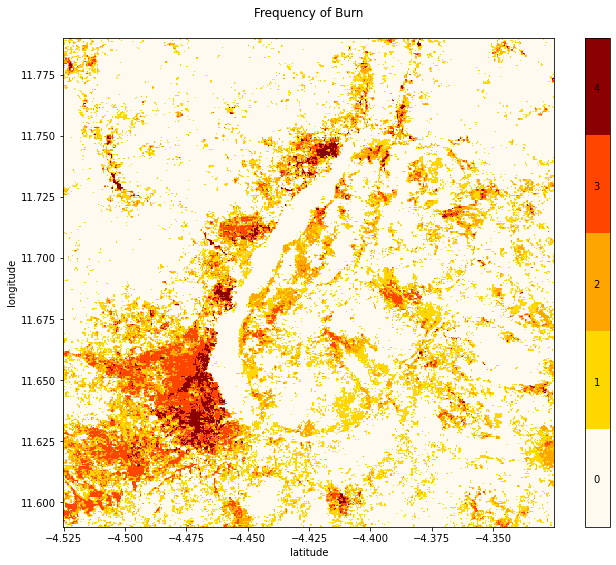

In [46]:
# Iterating over all loaded years for calculating frequency of burning
for i in range(0,len(list_years)-1 ):
    
    # Select pre, during and post fire timeframe and calculate median
    pre_year = list_years[i]
    post_year = list_years[i + 1]
    pre_image = dc_reproject.sel(time=slice(str(pre_year) + '-10-01', str(pre_year) + '-10-31')).median(dim='time')
    post_image = dc_reproject.sel(time=slice(str(post_year) + '-04-01', str(post_year) + '-04-30')).median(dim='time')
    
    # Selecting NBR bands
    pre_NBR_img = pre_image.NBR
    post_NBR_img = post_image.NBR
    
    # Calculating delta NBR
    delta_NBR = pre_NBR_img - post_NBR_img
    # Set threshold
    threshold = 0.44 #moderate-high severity burn
    # Apply threshold
    burnt = delta_NBR > threshold
    # Converting True/False image into int image[1,0]
    burnt=burnt*1
    
    # first run initiating frequency map
    if i==0:
        frequency = burnt
        
    #adding up values to frequency
    else:
        frequency+=burnt

# Creating own colorramp and adding it to plot
cmap = ListedColormap(['floralwhite', 'gold', 'orange', 'orangered', 'darkred'])

# Create Plot for Frequency of 
fig = frequency.plot(cmap=cmap, figsize=(11, 9), add_colorbar=False)

# Set colorbar options
cbar=plt.colorbar(fig)
cbar.set_ticks(list())
for index, label in  enumerate(["0", "1", "2", "3", "4"]):
    x = 0.35
    y = ((2 * index+0.9 ) / 2.5)
    cbar.ax.text(x, y, label)

plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Frequency of Burn\n')

plt.show()

### Conclusion
The normalized burn ratio as well as the delta normalized burn ratio can be used to detect areas where a burning event might have happend. <br> 
Thereby the dNBR analyses the change over the burning season even more precicely. In combination with a threshold, the actual area which burned can be filtered. For some years the acutal burnt area might be lager than calculated, since some areas in the scene are covered by clouds. <br>
Extending the time frame starting in 2013 until now revealed that the total area in which fires were detected is larger than 2017 and 2018. <br>
Therefore, the trend which might be concluded from the 4 years represented in this notebook might not represent an actual increase in burnt areas, but rather continuous burning events throughout the years. The closer look at the frequency of the burning events also revealed that most areas did not burn in the time frame or unly burnt once, except for one larger region south of the Tere Forest. In this area a mixture of agricultural fields next to some small forest areas can be found.
The Landsat-8 data used in this project is well suited for the purpose since the spatial resolution seems to be enough and the revisit time of 8 days provided at least one image per predefined season. 

For analysing whether an actual burning event happend in the areas where the dNBR was greater than 0.44 a dataset of tracked fires was used to identify the past fires in the region. The comparision between the NBR and the actual mapped fires can be found in the **script**

## References
Lui, J.; Maeda, E.; Wang, D.; Heiskanen, J. Sensitivity of Spetral Indices on Burned Area Detection using Landsat Time Series in Savannas of Southern Burkina Faso. In Remote Sensing; 2021; Volume 13(13), pp. 2492-2504.


Gessner, U.; Knauer, K.; Kuenzer, C.; Dech, S. Land Surface Phenology in a West African Savanna: Impact of Land Use, Land Cover and Fire. In Remote Sensing Time Series; Kuenzer, C., Dech, S., Wagner, W., Eds.; Remote Sensing and Digital Image Processing; Springer International Publishing: Dordrecht, The Netherlands, 2015; Volume 22, pp. 203–223.